In [1]:
%pylab inline
import seaborn as sns 
plt.style.use('seaborn-darkgrid')
sns.set(font_scale=2)
warnings.filterwarnings(action="ignore")

Populating the interactive namespace from numpy and matplotlib


In [2]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [3]:
import os

data_dir = '../CNN/donnees'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [4]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

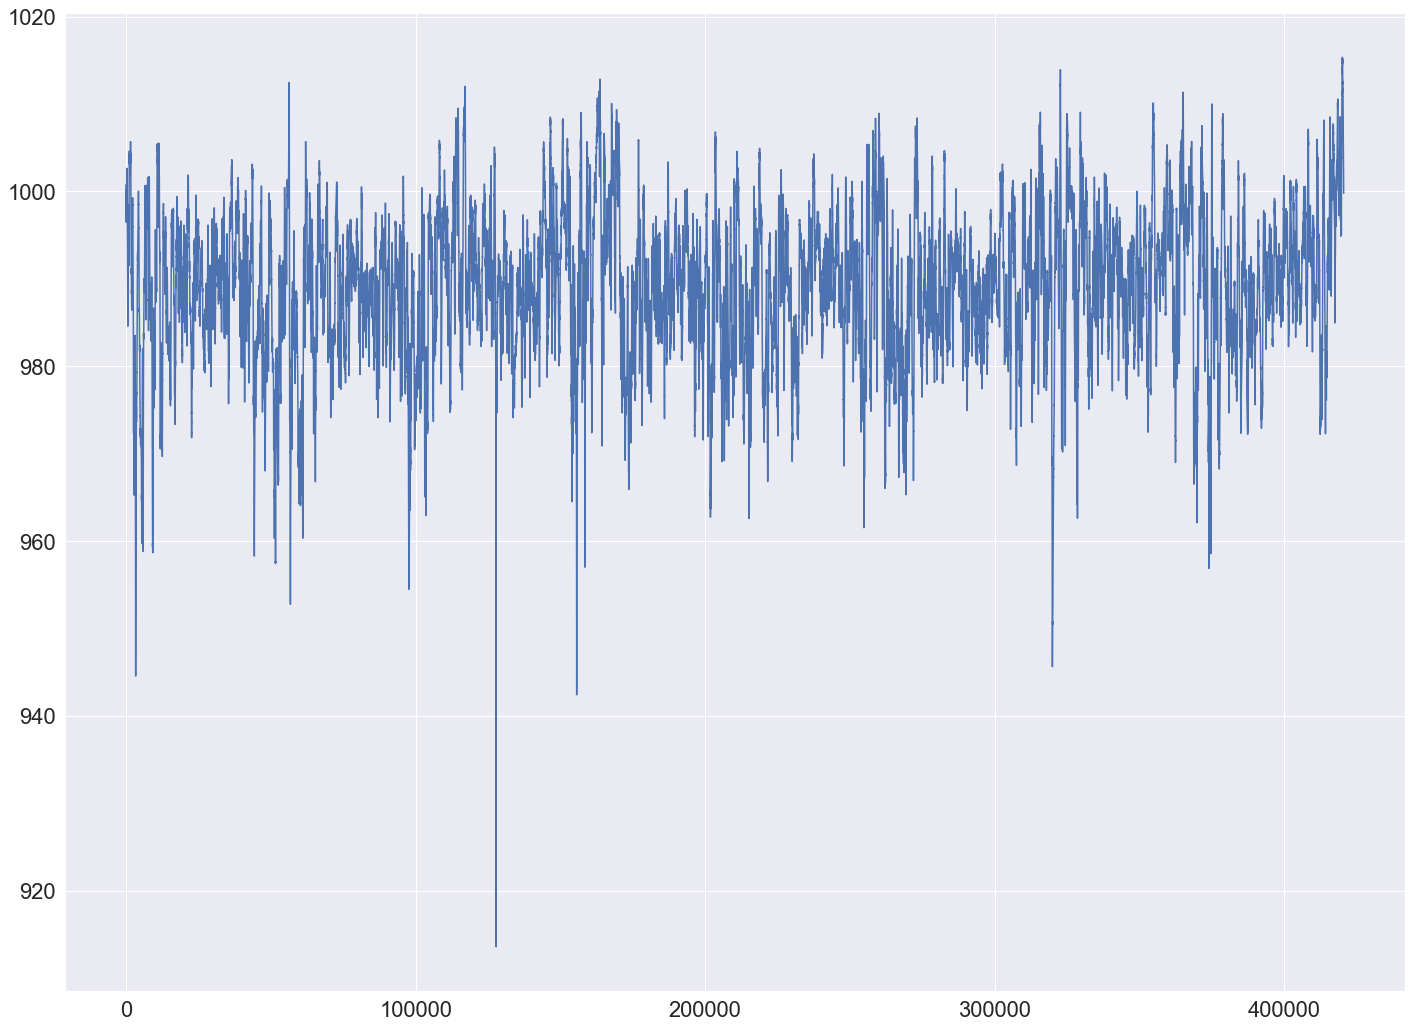

In [5]:
from matplotlib import pyplot as plt

temp = float_data[:, 0]  
plt.figure(figsize=(24,18))
plt.plot(range(len(temp)), temp)
plt.show()

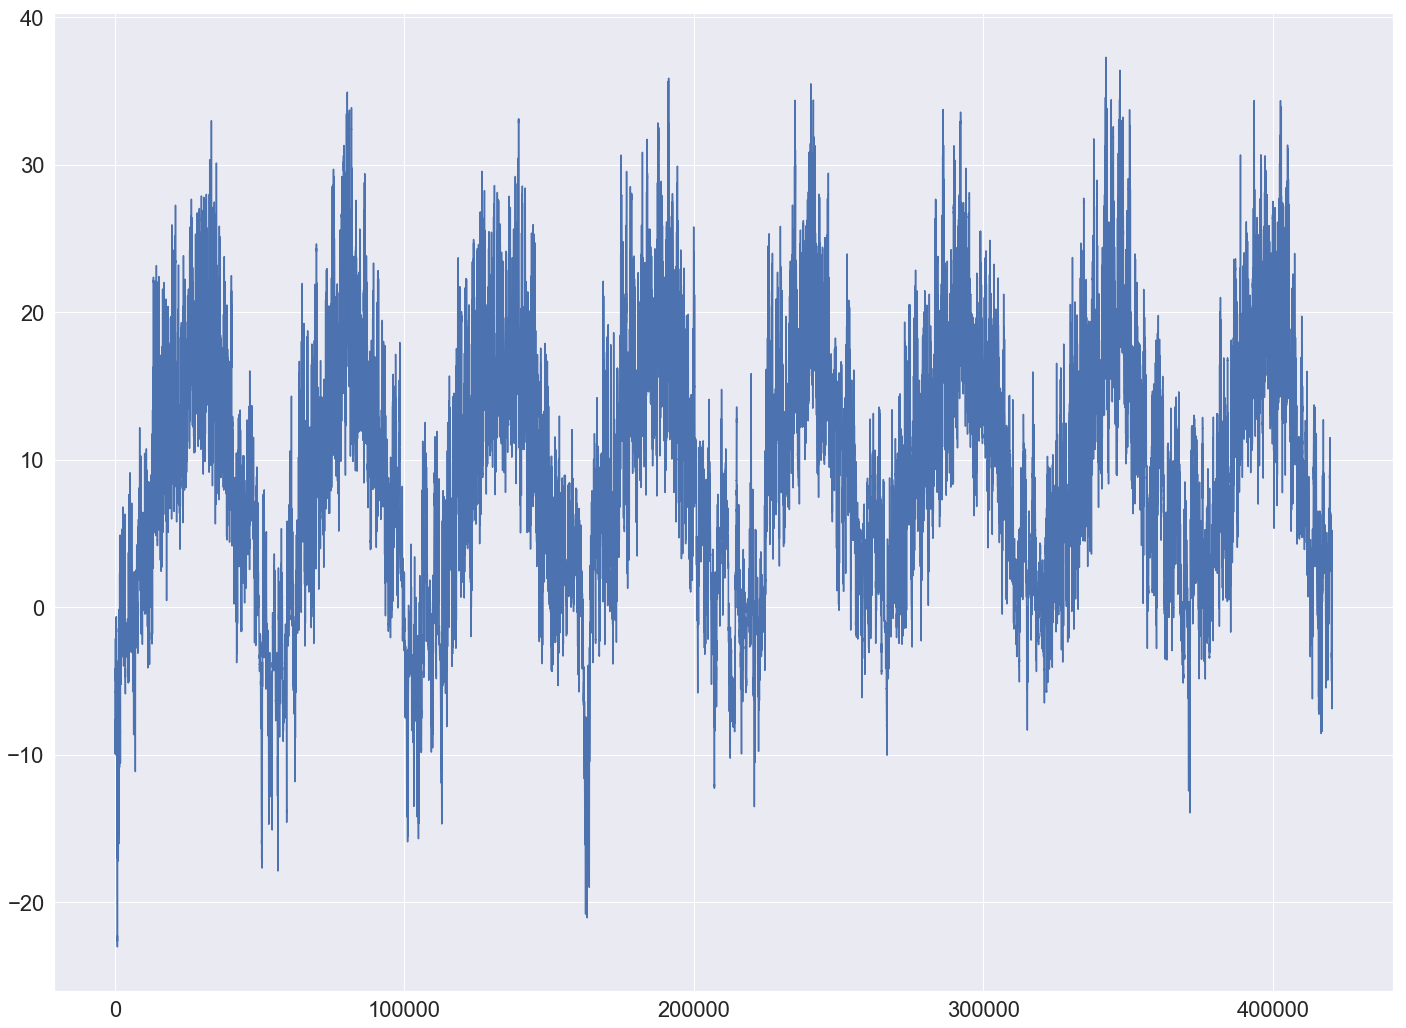

In [6]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # temperature (in degrees Celsius)
plt.figure(figsize=(24,18))
plt.plot(range(len(temp)), temp)
plt.show()

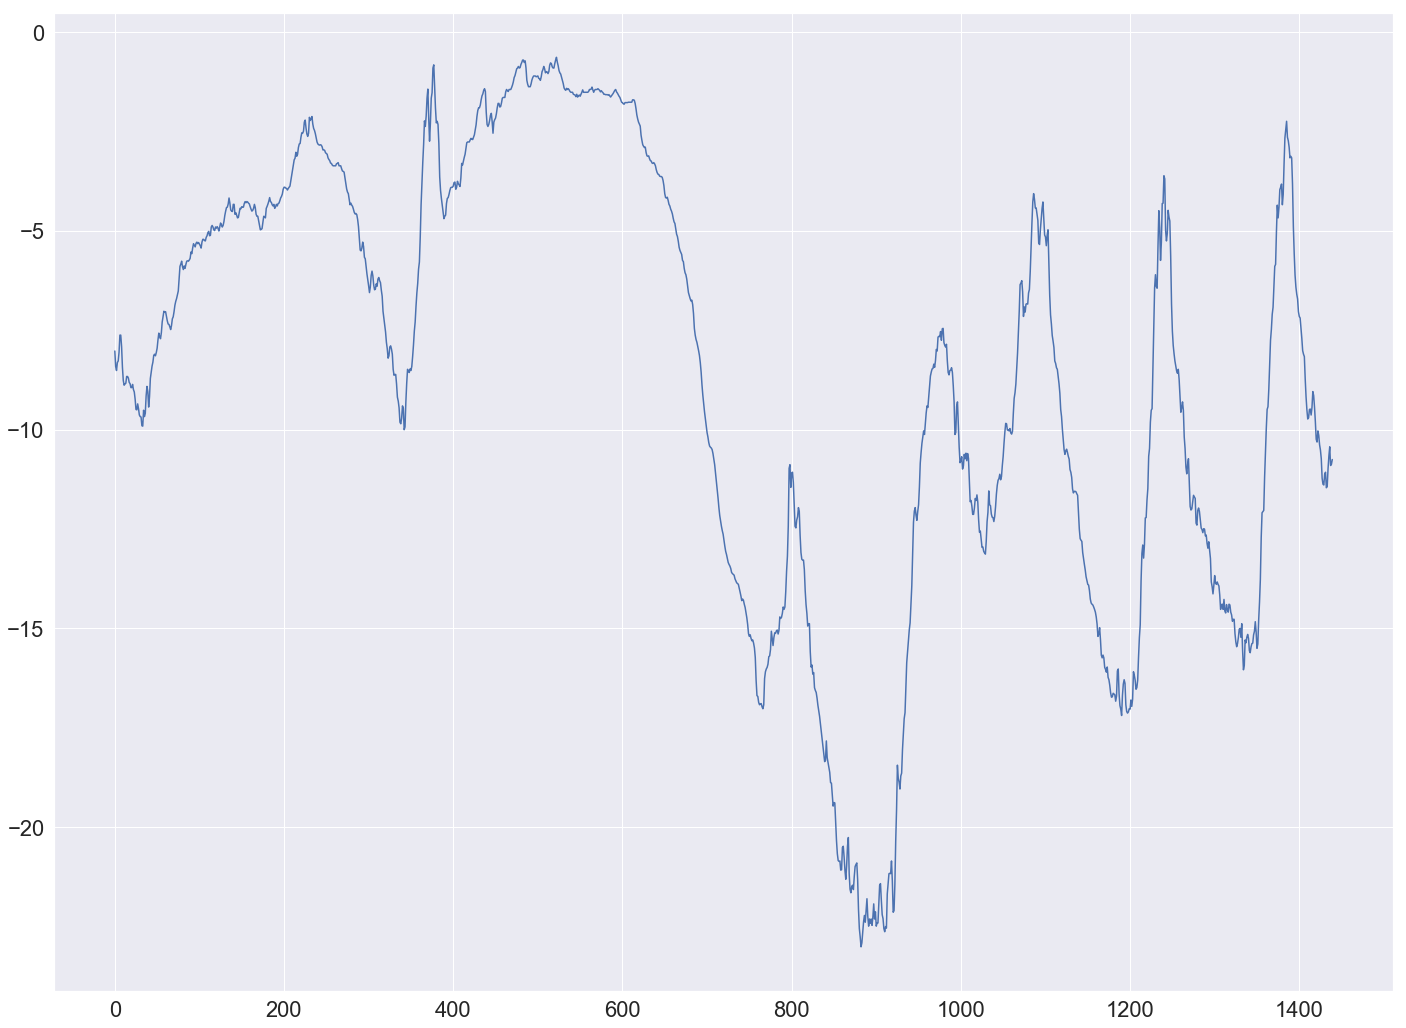

In [7]:
plt.figure(figsize=(24,18))
plt.plot(range(1440), temp[:1440])
plt.show()

In [8]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [9]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [10]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [11]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


In [12]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=4,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/4
500/500 [==============================] - 38s 76ms/step - loss: 0.9742 - val_loss: 0.5064
Epoch 2/4
500/500 [==============================] - 37s 75ms/step - loss: 0.3641 - val_loss: 0.3517
Epoch 3/4
500/500 [==============================] - 37s 74ms/step - loss: 0.2865 - val_loss: 0.2968
Epoch 4/4
500/500 [==============================] - 37s 74ms/step - loss: 0.2688 - val_loss: 0.3311


In [13]:
history.history

{'val_loss': [0.5063598738748324,
  0.35165561258947897,
  0.29677308557896603,
  0.33111679250730497],
 'loss': [0.974196722149849,
  0.36410213842988015,
  0.2865001105964184,
  0.26877688059210775]}

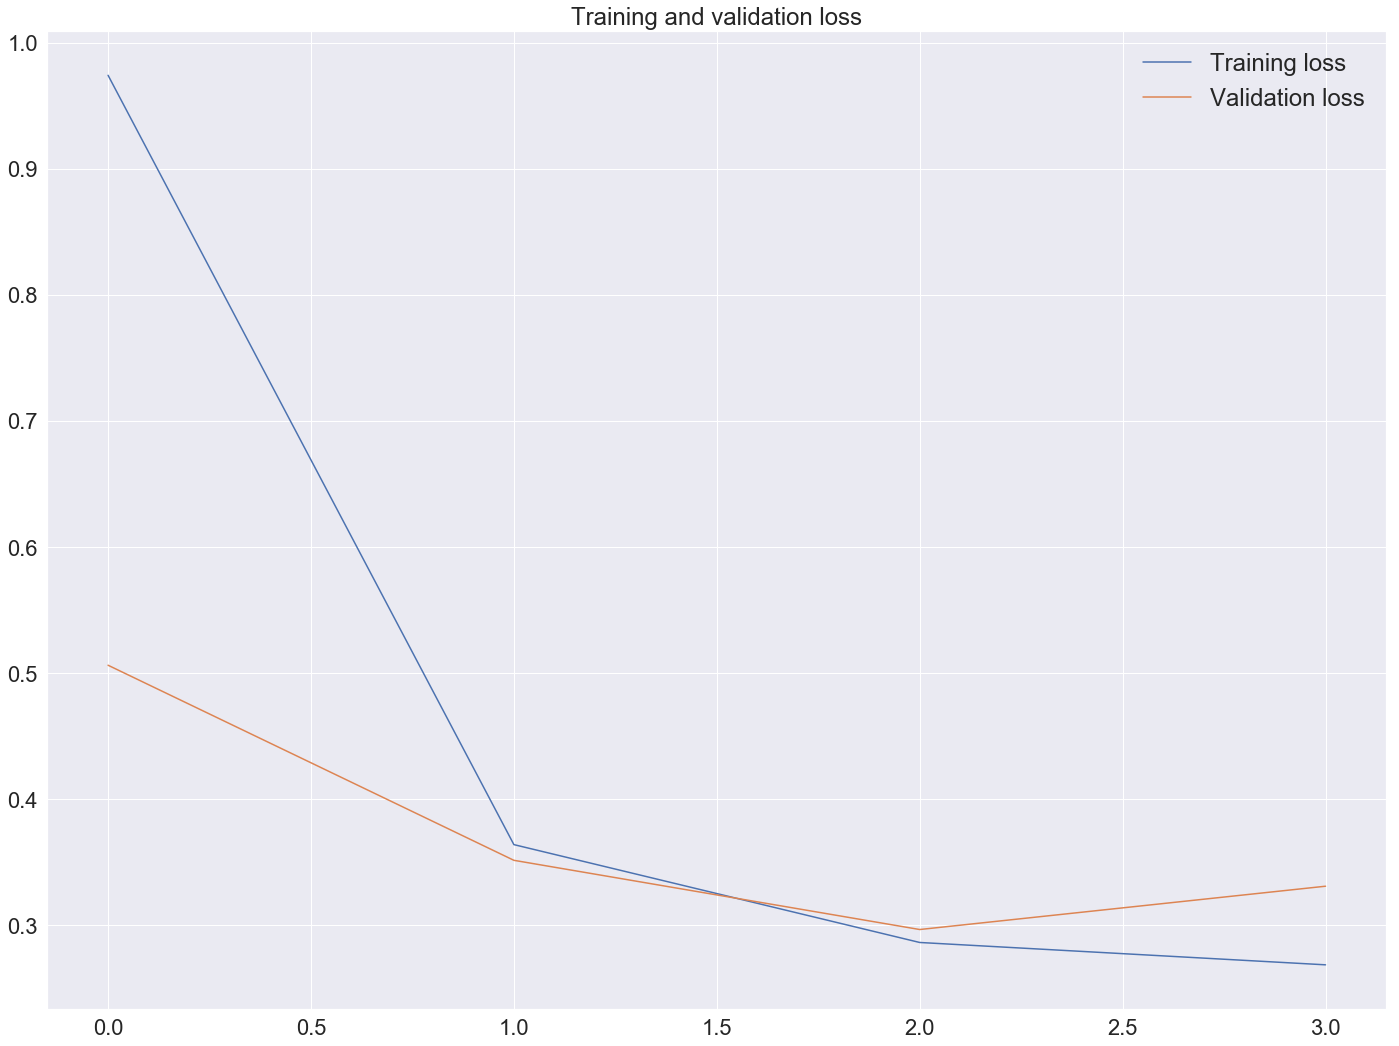

In [14]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure(figsize=(24,18))

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss', fontsize=24)
plt.legend(fontsize=24)

plt.show()

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.LSTM(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=4,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/4
500/500 [==============================] - 199s 399ms/step - loss: 0.3025 - val_loss: 0.2685
Epoch 2/4
500/500 [==============================] - 434s 868ms/step - loss: 0.2784 - val_loss: 0.2690
Epoch 3/4
500/500 [==============================] - 229s 457ms/step - loss: 0.2685 - val_loss: 0.2697
Epoch 4/4
499/500 [============================>.] - ETA: 0s - loss: 0.2576

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))


plt.figure(figsize=(24,18))

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss', fontsize=24)
plt.legend(fontsize=24)

plt.show()